In [2]:
import getpass
import os

if not os.environ.get("AZURE_OPENAI_API_KEY"):
  os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass("Enter API key for Azure: ")

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment="gpt-4o-mini",
    openai_api_version="2024-02-15-preview",
)

In [3]:
llm.invoke("Hello, world! You are a teaching assistant?")

AIMessage(content='Hello! Yes, I can assist with teaching and provide information on a variety of topics. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 17, 'total_tokens': 42, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_04751d0b65', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, '

In [4]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [7]:
import json

with open('article_links.json', 'r') as f:
    article_li = json.load(f)
# list(article_li.values())

# for title, link in article_li:
#     print(link)

In [8]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=(list(article_li.values())),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

In [20]:

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [15]:
print(f"Total characters: {len(docs[0].page_content)}")
print(docs[0].page_content[:500])

Total characters: 50483


      Reward Hacking in Reinforcement Learning
    
Date: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng


Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.
With the rise of


In [11]:
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 2553 sub-documents.


In [12]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is the process of breaking down complex tasks into smaller, manageable steps to facilitate easier completion. This can be achieved through techniques like Chain of Thought (CoT) and the Tree of Thoughts, which allow for structured reasoning and exploration of multiple possibilities. By decomposing tasks, models can better plan and execute their responses, enhancing overall performance.


In [13]:
response = graph.invoke({"question": "What are transformers"})
response

{'question': 'What are transformers',
 'context': [Document(id='092f4799-122e-4051-be10-5b64267e2736', metadata={'source': 'https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/'}, page_content='Transformer Basics#\nThe Transformer (which will be referred to as “vanilla Transformer” to distinguish it from other enhanced versions; Vaswani, et al., 2017) model has an encoder-decoder architecture, as commonly used in many NMT models. Later simplified Transformer was shown to achieve great performance in language modeling tasks, like in encoder-only BERT or decoder-only GPT.\nAttention and Self-Attention#\nAttention is a mechanism in neural network that a model can learn to make predictions by selectively attending to a given set of data. The amount of attention is quantified by learned weights and thus the output is usually formed as a weighted average.\nSelf-attention is a type of attention mechanism where the model makes prediction for one part of a data sample using 

In [14]:
response = graph.invoke({"question": "What does Presidio do?"})
print(response["answer"])

Presidio is not explicitly mentioned in the provided context, so I don't know what it does.


In [38]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=5, fetch_k=5)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [39]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [40]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
# graph_builder.remove_node(generate)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

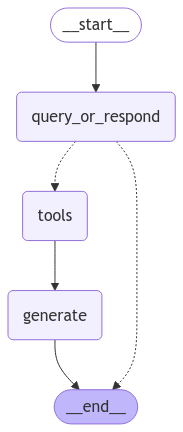

In [45]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [35]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [29]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_VqGkwvWhg0Gyrsow86yBI63H)
 Call ID: call_VqGkwvWhg0Gyrsow86yBI63H
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms b

In [42]:
retrieve(input_message)

"Source: {'source': 'https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/'}\nContent: Transformer Basics#\nThe Transformer (which will be referred to as “vanilla Transformer” to distinguish it from other enhanced versions; Vaswani, et al., 2017) model has an encoder-decoder architecture, as commonly used in many NMT models. Later simplified Transformer was shown to achieve great performance in language modeling tasks, like in encoder-only BERT or decoder-only GPT.\nAttention and Self-Attention#\nAttention is a mechanism in neural network that a model can learn to make predictions by selectively attending to a given set of data. The amount of attention is quantified by learned weights and thus the output is usually formed as a weighted average.\nSelf-attention is a type of attention mechanism where the model makes prediction for one part of a data sample using other parts of the observation about the same sample. Conceptually, it feels quite similar to non-local mean

In [47]:
input_message = "What are transformers"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are transformers
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_eoDxmY0FuNRGRUwenTJSrjZX)
 Call ID: call_eoDxmY0FuNRGRUwenTJSrjZX
  Args:
    query: transformers
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/'}
Content: Transformer Basics#
The Transformer (which will be referred to as “vanilla Transformer” to distinguish it from other enhanced versions; Vaswani, et al., 2017) model has an encoder-decoder architecture, as commonly used in many NMT models. Later simplified Transformer was shown to achieve great performance in language modeling tasks, like in encoder-only BERT or decoder-only GPT.
Attention and Self-Attention#
Attention is a mechanism in neural network that a model can learn to make p

In [48]:
input_message = "How is it different from a generator?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How is it different from a generator?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_E3MjQrw4DBltZzGtiphQJV0R)
 Call ID: call_E3MjQrw4DBltZzGtiphQJV0R
  Args:
    query: difference between transformers and generators in machine learning
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/'}
Content: Transformer Basics#
The Transformer (which will be referred to as “vanilla Transformer” to distinguish it from other enhanced versions; Vaswani, et al., 2017) model has an encoder-decoder architecture, as commonly used in many NMT models. Later simplified Transformer was shown to achieve great performance in language modeling tasks, like in encoder-only BERT or decoder-only GPT.
Attention and Self-Attention#
Atten

In [49]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

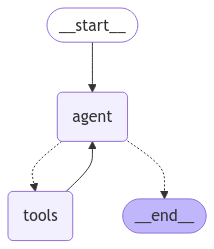

In [50]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [51]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_0mum6sQ5pxBHxDedxgTpUbfG)
 Call ID: call_0mum6sQ5pxBHxDedxgTpUbfG
  Args:
    query: standard method for Task Decomposition
  retrieve (call_4DPbDQMt3rZYCwsEGvTty4OQ)
 Call ID: call_4DPbDQMt3rZYCwsEGvTty4OQ
  Args:
    query: common extensions of Task Decomposition method
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure